In [1]:
import torch
import torch_geometric
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

In [2]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

In [3]:
data = dataset[0]
print("shapes of list of edges, list of nodes w/ features and of class to predict")
print(data)
print("data is undirected?", data.is_undirected())
print("data has self loops?", data.contains_self_loops())

shapes of list of edges, list of nodes w/ features and of class to predict
Data(edge_index=[2, 168], x=[37, 3], y=[1])
data is undirected? True
data has self loops? False


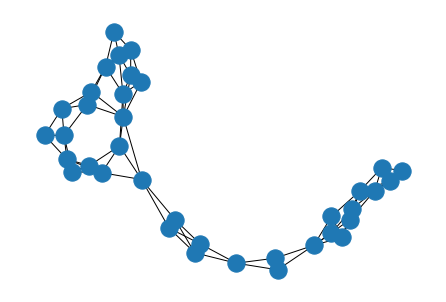

In [4]:
import networkx as nx
import torch_geometric
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g)

In [5]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

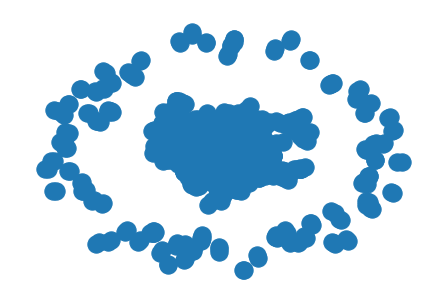

In [6]:
import networkx as nx
import torch_geometric
g = torch_geometric.utils.to_networkx(dataset[0], to_undirected=True)
nx.draw(g)

In [7]:
from ocpmodels.preprocessing import AtomsToGraphs
from ocpmodels.datasets import SinglePointLmdbDataset, TrajectoryLmdbDataset
import ase.io
from ase.build import bulk
from ase.build import fcc100, add_adsorbate, molecule
from ase.constraints import FixAtoms
from ase.calculators.emt import EMT
from ase.optimize import BFGS
import matplotlib.pyplot as plt
import lmdb
import pickle
from tqdm import tqdm
import torch
import os

In [9]:
# dataset at D:\is2res_train_val_test_lmdbs\data\is2re\10k\train

dataset = SinglePointLmdbDataset({"src": "D:\\is2res_train_val_test_lmdbs\\data\\is2re\\10k\\train\\data.lmdb"})
print(dataset)

In [10]:
print(dataset[0])

Data(atomic_numbers=[86], cell=[1, 3, 3], cell_offsets=[2964, 3], distances=[2964], edge_index=[2, 2964], fixed=[86], force=[86, 3], natoms=86, pos=[86, 3], pos_relaxed=[86, 3], sid=2472718, tags=[86], y_init=6.282500615000004, y_relaxed=-0.025550085000020317)


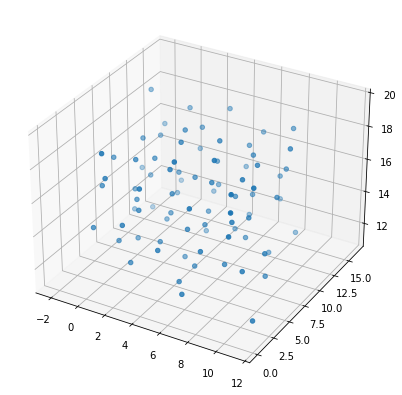

In [11]:
from mpl_toolkits import mplot3d
import numpy as np

#print(dataset[0].pos)
x = dataset[0].pos[:,0]
y = dataset[0].pos[:,1]
z = dataset[0].pos[:,2]

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x, y, z)
 
# show plot
plt.show()

In [12]:
symbols = ["H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca", "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr", "Y", "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Xe", "Cs", "Ba", "La", "Ce", "Pr", "Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg", "Tl", "Pb", "Bi", "Po", "At", "Rn", "Fr", "Ra", "Ac", "Th", "Pa", "U", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm", "Md", "No", "Lr", "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds", "Rg", "Cn", "Uut", "Fl", "Uup", "Lv", "Uus", "Uuo"]

In [13]:
from ase.io import read
from ase.visualize import view

i = 0
print(dataset[i])

x = dataset[i].pos[:,0]
y = dataset[i].pos[:,1]
z = dataset[i].pos[:,2]
atom = dataset[i].atomic_numbers

f = open("adsPicture.xyz", "w")
f.write(str(len(atom))+"\n")
for i in range(len(atom)):
    f.write("\n{}\t {}\t {}\t {}".format(symbols[int(atom[i])-1],x[i],y[i],z[i]))
f.close()


pic = read("adsPicture.xyz")
view(pic)

Data(atomic_numbers=[86], cell=[1, 3, 3], cell_offsets=[2964, 3], distances=[2964], edge_index=[2, 2964], fixed=[86], force=[86, 3], natoms=86, pos=[86, 3], pos_relaxed=[86, 3], sid=2472718, tags=[86], y_init=6.282500615000004, y_relaxed=-0.025550085000020317)


In [14]:
print(dataset[0])

Data(atomic_numbers=[86], cell=[1, 3, 3], cell_offsets=[2964, 3], distances=[2964], edge_index=[2, 2964], fixed=[86], force=[86, 3], natoms=86, pos=[86, 3], pos_relaxed=[86, 3], sid=2472718, tags=[86], y_init=6.282500615000004, y_relaxed=-0.025550085000020317)


In [26]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [27]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 3)

    def forward(self, data):
        x, edge_index = data.pos, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [54]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from ocpmodels.datasets.embeddings import KHOT_EMBEDDINGS, QMOF_KHOT_EMBEDDINGS, ATOMIC_RADII

class messageLayer(MessagePassing):
    
    def __init__(self, node_dim, edge_dim):
        super(messageLayer, self).__init__(aggr="mean")
        self.node_dim = node_dim
        self.edge_dim = edge_dim
        
        self.msg1 = nn.Linear(2*self.node_dim + self.edge_dim, self.node_dim)
        
    def message(self, x_i, x_j, edge_attr):
        
        x = self.msg1(torch.cat([x_i, x_j, edge_attr], dim=1))
        
    def forward(self, x_emb, edge_index, edge_attr):
        num_nodes = x_emb.shape[0]
        print(num_nodes)
        
        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)
        
        

In [55]:
from torch import nn

class messageGNN(torch.nn.Module):
    
    def __init__(self, atom_embedding_size, edge_embedding_size):
        super(messageGNN, self).__init__()
        
        self.atom_embedding_size = atom_embedding_size
        self.edge_embedding_size = edge_embedding_size
        
        # get embeddings list
        embeddings = KHOT_EMBEDDINGS
        # create copy of embeddings as torch tensor
        self.embedding = torch.zeros(100, len(embeddings[1]))
        for i in range(100):
            # don't forget that elements start at 1 
            self.embedding[i] = torch.tensor(embeddings[i + 1])
        # learnable layer to compress embedding
        self.embedding_fc = nn.Linear(len(embeddings[1]), self.atom_embedding_size)
        
        self.msg1 = messageLayer(self.atom_embedding_size, self.edge_embedding_size)
        
        self.lin1 = nn.Linear(self.atom_embedding_size, 3)
        
    def forward(self, data):
        print(data)
        # get attributes from data
        x_atom, x_pos = data.atomic_numbers, data.pos
        edge_index, edge_dist = data.edge_index, data.distances
        
        # find condensed embeddings for atoms
        # element number -> big embedding -> small embedding
        x_emb = self.embedding_fc(self.embedding[x_atom.long()])
        
        # do message passing with embeddings 
        x = self.msg1(x_emb, edge_index, edge_dist)
        
        # turn result from size of node embedding to size of goal
        x = self.lin1(x)
        return x
        

In [56]:
# Message GNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = messageGNN(16, 1).to(device)
data = train_loader
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(20):
    for batch in data:
        optimizer.zero_grad()
        out = model(batch)
        #print(out.shape)
        #print(data.pos_relaxed)
        loss = ((out-data.pos_relaxed)**2).sum()
        #print(loss.shape)
        print("loss =", loss.detach().numpy())
        #loss = torch.cdist(out, data.pos_relaxed)
        loss.backward()
        optimizer.step()

Batch(atomic_numbers=[132], batch=[132], cell=[1, 3, 3], cell_offsets=[5612, 3], distances=[5612], edge_index=[2, 5612], fixed=[132], force=[132, 3], natoms=[1], pos=[132, 3], pos_relaxed=[132, 3], ptr=[2], sid=[1], tags=[132], y_init=[1], y_relaxed=[1])
132
torch.Size([2, 5698])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 16)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(20000):
    optimizer.zero_grad()
    out = model(data)
    #print(out.shape)
    #print(data.pos_relaxed)
    loss = ((out-data.pos_relaxed)**2).sum()
    #print(loss.shape)
    print("loss =", loss.detach().numpy())
    #loss = torch.cdist(out, data.pos_relaxed)
    loss.backward()
    optimizer.step()

In [151]:
out = model(data).detach().numpy()
#print(out)
x = out[:,0]
y = out[:,1]
z = out[:,2]
atom = dataset[0].atomic_numbers

f = open("adsPicture.xyz", "w")
f.write(str(len(atom))+"\n")
for i in range(len(atom)):
    f.write("\n{}\t {}\t {}\t {}".format(symbols[int(atom[i])-1],x[i],y[i],z[i]))
f.close()


pic = read("adsPicture.xyz")
view(pic)

In [152]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

AttributeError: 'Data' object has no attribute 'test_mask'